In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [160]:
# uncomment if using colab
! git clone https://github.com/Daniel-Tran3/CSE_151A_Project.git

fatal: destination path 'CSE_151A_Project' already exists and is not an empty directory.


In [161]:
#original_df = pd.read_csv('apartments_for_rent_classified_10K_utf.csv')

# uncomment the following if using colab
original_df = pd.read_csv('CSE_151A_Project/apartments_for_rent_classified_10K_utf.csv')

In [162]:
df = original_df[["amenities", "bathrooms", "bedrooms", "fee", "price", "price_type", "square_feet", "cityname", "state", "time"]]

In [163]:
df.head(5)

,amenities,bathrooms,bedrooms,fee,price,price_type,square_feet,cityname,state,time
0,NaN,NaN,0.0,No,790,Monthly,101,Washington,DC,1577359415
1,NaN,NaN,1.0,No,425,Monthly,106,Evansville,IN,1577017063
2,NaN,1.0,0.0,No,1390,Monthly,107,Arlington,VA,1577359410
3,NaN,1.0,0.0,No,925,Monthly,116,Seattle,WA,1576667743
4,NaN,NaN,0.0,No,880,Monthly,125,Arlington,VA,1577359401


In [164]:
df.isna().mean()

amenities      0.3549
bathrooms      0.0034
bedrooms       0.0007
fee            0.0000
price          0.0000
price_type     0.0000
square_feet    0.0000
cityname       0.0077
state          0.0077
time           0.0000
dtype: float64

## Convert timestamp to datetime objects

In [165]:
df['time'] = pd.to_datetime(df['time'], unit='s')

In [166]:
df.head(2)

,amenities,bathrooms,bedrooms,fee,price,price_type,square_feet,cityname,state,time
0,NaN,NaN,0.0,No,790,Monthly,101,Washington,DC,2019-12-26 11:23:35
1,NaN,NaN,1.0,No,425,Monthly,106,Evansville,IN,2019-12-22 12:17:43


## Normalizing Price and Square Feet


Convert any prices measured in Weeks to Months by converting to price per day then price per year then price per month (roughly 4.348 multiplier).

There is one abnormally high price with 'weekly' price_type. The price for 'week' is 1560, and digging into the dataset, we found that it is a duplicate of index 15. The listing is for the same place except it's on another listing website. This duplicate will be dropped in favor of the other one.

There is also one record with 'Monthly|Weekely' price_type with a price of 275.0, and the price is likely to be on a weekly basis.

In [167]:
df[df['price'] == 1560][:2]

,amenities,bathrooms,bedrooms,fee,price,price_type,square_feet,cityname,state,time
15,"AC,Basketball,Cable or Satellite,Gym,Internet ...",1.0,1.0,No,1560,Weekly,200,New Bern,NC,2019-12-17 21:27:56
16,"AC,Basketball,Cable or Satellite,Gym,Internet ...",1.0,1.0,No,1560,Monthly,200,New Bern,NC,2019-12-15 10:37:53


In [168]:
# Drop the wrong record?
# df = df.drop([16,17])

df = df.drop([15,16])

In [169]:
df[df['price_type'] == 'Monthly|Weekly']

,amenities,bathrooms,bedrooms,fee,price,price_type,square_feet,cityname,state,time
235,"Cable or Satellite,Pool,Refrigerator,Storage,TV",NaN,NaN,No,275,Monthly|Weekly,300,Lakeland,FL,2019-11-27 21:43:20


In [170]:
# DO NOT NORMALIZE IT WILL BECOME NON-INTERPRETABLE
# for i in df.index:
#   if (df['price_type'][i] == "Weekly") or (df['price_type'][i] == "Monthly/Weekly"):
#     df.loc[i, 'price'] = df['price'][i] / 7 * 365.25 / 12

# df['price'] = (df['price'] - df['price'].min()) / (df['price'].max() - df['price'].min())

In [171]:
print(df['price'].min())
print(df['price'].max())

200
52500


Since we have standardized the units of the price, we can drop the price_type column.

In [172]:
df = df.drop(columns=['price_type'])

## Normalize the square_feet using Min Max method

In [173]:
df['square_feet'] = (df['square_feet'] - df['square_feet'].min()) / (df['square_feet'].max() - df['square_feet'].min())

In [174]:
print(df['square_feet'].min())
print(df['square_feet'].max())

0.0
1.0


## Impute NaN values using median

In [175]:
df['bathrooms'] = df['bathrooms'].replace({np.nan: df['bathrooms'].median()})

In [176]:
df['bedrooms'] = df['bedrooms'].replace({np.nan: df['bedrooms'].median()})

## Preprocessing on the amenities

In [177]:
df['amenities'] = np.array(df['amenities'].str.strip().str.split(","))

In [178]:
df

,amenities,bathrooms,bedrooms,fee,price,square_feet,cityname,state,time
0,NaN,1.0,0.0,No,790,0.000000,Washington,DC,2019-12-26 11:23:35
1,NaN,1.0,1.0,No,425,0.000125,Evansville,IN,2019-12-22 12:17:43
2,NaN,1.0,0.0,No,1390,0.000150,Arlington,VA,2019-12-26 11:23:30
3,NaN,1.0,0.0,No,925,0.000376,Seattle,WA,2019-12-18 11:15:43
4,NaN,1.0,0.0,No,880,0.000602,Arlington,VA,2019-12-26 11:23:21
...,...,...,...,...,...,...,...,...,...
9995,NaN,4.0,5.0,No,6000,0.155367,Edina,MN,2019-11-30 11:22:55
9996,NaN,8.0,6.0,No,25000,0.215920,Montecito,CA,2019-12-26 11:40:19
9997,NaN,8.5,6.0,No,11000,0.281135,Potomac,MD,2019-12-26 11:42:40
9998,"[Basketball, Cable or Satellite, Doorman, Hot ...",1.0,1.0,No,4790,1.000000,New York,NY,2019-12-26 12:09:46


In [179]:
df['amenities'] = df['amenities'].replace({np.nan: 'None'})

In [180]:
df.head(5)

,amenities,bathrooms,bedrooms,fee,price,square_feet,cityname,state,time
0,None,1.0,0.0,No,790,0.000000,Washington,DC,2019-12-26 11:23:35
1,None,1.0,1.0,No,425,0.000125,Evansville,IN,2019-12-22 12:17:43
2,None,1.0,0.0,No,1390,0.000150,Arlington,VA,2019-12-26 11:23:30
3,None,1.0,0.0,No,925,0.000376,Seattle,WA,2019-12-18 11:15:43
4,None,1.0,0.0,No,880,0.000602,Arlington,VA,2019-12-26 11:23:21


## One-hot Encoding States and City Names
States and city names are nominal categorical features. To deal with this, we will be creating one-hot encoded fields to reflect each data points location.

In [181]:
all_states = df['state'].unique()
all_states

array(['DC', 'IN', 'VA', 'WA', 'NY', 'CA', 'AZ', 'TX', 'GA', 'NC', 'FL',
       nan, 'AL', 'MD', 'CO', 'NM', 'IL', 'TN', 'AK', 'MA', 'NJ', 'OR',
       'DE', 'PA', 'IA', 'SC', 'MN', 'MI', 'KY', 'WI', 'OH', 'CT', 'RI',
       'NV', 'UT', 'MO', 'OK', 'NH', 'NE', 'LA', 'ND', 'AR', 'KS', 'ID',
       'HI', 'MT', 'VT', 'SD', 'WV', 'MS', 'ME', 'WY'], dtype=object)

In [182]:
display(df['state'].value_counts())

display(df['cityname'].value_counts())

TX    1737
CA     955
WA     519
NC     436
MD     424
NJ     383
GA     372
FL     339
OH     321
CO     318
WI     302
IL     282
MO     239
IN     239
MN     221
VA     205
OR     197
PA     183
IA     179
OK     178
MI     176
MA     167
AZ     126
NV     121
ND     113
NE     105
CT      98
TN      92
UT      84
KS      83
DC      80
SC      77
NY      71
NH      70
SD      66
LA      66
AL      56
AR      56
AK      44
KY      40
ID      21
VT      16
NM      14
HI      12
RI      11
MS       9
MT       7
DE       5
WV       3
ME       2
WY       1
Name: state, dtype: int64

Austin           523
Dallas           216
Houston          186
San Antonio      182
Los Angeles      165
                ... 
Keizer             1
Keyser             1
Pompano Beach      1
Kaysville          1
Bella Vista        1
Name: cityname, Length: 1573, dtype: int64

In [183]:
df = pd.get_dummies(df, columns=['state', 'cityname'], dummy_na=True)

In [184]:
df.head()

,amenities,bathrooms,bedrooms,fee,price,square_feet,time,state_AK,state_AL,state_AR,...,cityname_York,cityname_Yorktown,cityname_Yorkville,cityname_Youngstown,cityname_Youngsville,cityname_Ypsilanti,cityname_Yuba City,cityname_Yukon,cityname_Zachary,cityname_nan
0,None,1.0,0.0,No,790,0.000000,2019-12-26 11:23:35,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,None,1.0,1.0,No,425,0.000125,2019-12-22 12:17:43,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,None,1.0,0.0,No,1390,0.000150,2019-12-26 11:23:30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,None,1.0,0.0,No,925,0.000376,2019-12-18 11:15:43,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,None,1.0,0.0,No,880,0.000602,2019-12-26 11:23:21,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
# extract unknown cities and states
unknown_city = df[df['cityname_nan'] == 1]
unknown_state = df[df['state_nan'] == 1]
unknown_state

# find if there is intersection between unknown cities and states
print(unknown_city.shape[0])
print(unknown_state.shape[0])
len(unknown_city.index.intersection(unknown_state.index))

77
77


77

In [186]:
df['fee'].unique()

array(['No'], dtype=object)

In [187]:
final_cleaned = df.drop(columns=['fee'])
final_cleaned

,amenities,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,...,cityname_York,cityname_Yorktown,cityname_Yorkville,cityname_Youngstown,cityname_Youngsville,cityname_Ypsilanti,cityname_Yuba City,cityname_Yukon,cityname_Zachary,cityname_nan
0,None,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,None,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,None,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,None,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,None,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,None,4.0,5.0,6000,0.155367,2019-11-30 11:22:55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,None,8.0,6.0,25000,0.215920,2019-12-26 11:40:19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,None,8.5,6.0,11000,0.281135,2019-12-26 11:42:40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,"[Basketball, Cable or Satellite, Doorman, Hot ...",1.0,1.0,4790,1.000000,2019-12-26 12:09:46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## One hot encoding amenities

In [188]:
all_amenities = (final_cleaned['amenities'].explode()).unique()[1:]
final_cleaned = final_cleaned.reset_index(drop=True)
amenities = pd.DataFrame()

for a in all_amenities:
    amenities[a] = final_cleaned['amenities'].apply(lambda x: 1 if a in x else 0)
amenities.head()

,Dishwasher,Elevator,Patio/Deck,Pool,Storage,Refrigerator,Cable or Satellite,Clubhouse,Internet Access,Parking,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
final_cleaned = pd.concat([final_cleaned, amenities], axis=1).drop(columns='amenities')
final_cleaned.head()

,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model 1

In [190]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

# drop time since machine cant train on DateTime type
X = final_cleaned.drop(columns=['price', 'time'])
X_train, X_test, y_train, y_test = train_test_split(X, final_cleaned.price, test_size = 0.2, random_state = 42)

def buildHPmodel(hp):
  model = Sequential ([
        Dense(
            units=hp.Int("units", min_value=8, max_value=64, step=8),
            input_shape=(X_train.shape[1],),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        ),
      Dense(
          units = hp.Int("units", min_value = 8, max_value = 64, step = 8),
          activation = hp.Choice("activation", ["relu", "tanh"]),
      ),
      Dense(1, activation="relu")
  ])
  learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 0.3, sampling = "log")
  model.compile(optimizer = SGD(learning_rate = learning_rate), loss = 'mae', metrics = ['mse','mae'])
  return model

In [191]:
y_train

8964    1862
1561     850
1670    1220
4345     800
8099    1300
        ... 
5734    1010
5191    1736
5390    3159
860     1061
7270    1285
Name: price, Length: 7998, dtype: int64

In [192]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [193]:
import keras_tuner

In [194]:
hp = keras_tuner.HyperParameters()

In [195]:
# if changing any model parameters such as layers, activation function.
# plz remove the file "untitled_project/tuner0.json"
# otherwise, it will reload from the tuner config before modification.
tuner = keras_tuner.RandomSearch(
    hypermodel = buildHPmodel,
    objective = "val_mae",
    max_trials = 20,
    seed = 15,
    executions_per_trial = 5,
    tune_new_entries = True,
    allow_new_entries = True,
    max_consecutive_failed_trials = 3
)

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0)

In [197]:
tuner.search(X_train.astype('float'), y_train, epochs = 2, validation_data = (X_val, y_val))

Trial 20 Complete [00h 00m 18s]
val_mae: 1511.322509765625

Best val_mae So Far: 424.1709228515625
Total elapsed time: 00h 06m 31s


In [198]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 11 summary
Hyperparameters:
units: 40
activation: relu
lr: 0.005370255866801909
Score: 424.1709228515625

Trial 00 summary
Hyperparameters:
units: 64
activation: relu
lr: 0.006531325785134502
Score: 459.5944396972656

Trial 04 summary
Hyperparameters:
units: 48
activation: relu
lr: 0.008051492859765244
Score: 465.26427001953124

Trial 09 summary
Hyperparameters:
units: 48
activation: relu
lr: 0.002633472508903481
Score: 511.3033386230469

Trial 02 summary
Hyperparameters:
units: 16
activation: tanh
lr: 0.16438743694138194
Score: 663.5315307617187

Trial 01 summary
Hyperparameters:
units: 16
activation: tanh
lr: 0.140935034828769
Score: 716.1970947265625

Trial 08 summary
Hyperparameters:
units: 16
activation: relu
lr: 0.0021127841962961585
Score: 741.7893188476562

Trial 16 summary
Hyperparameters:
units: 32
activation: relu
lr: 0.0027676755379845196
Score: 808.1942932

In [199]:
# test regular
model = Sequential()

# Input layer (matches the number of features in your data)
model.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))

# Hidden layers (you can add more with different units)
model.add(Dense(24, activation='relu'))

# Output layer (units based on the number of classes)
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

X_train, X_test, y_train, y_test = train_test_split(X, final_cleaned.price, test_size = 0.2, random_state = 42)

history = model.fit(X_train,y_train, epochs=100, validation_split=0.2)
loss, mae, mse = model.evaluate(X_test, y_test)
print('MAE:', mae)
print('MSE:', mse)

Epoch 1/100
200/200 [==============================] - 2s 7ms/step - loss: 1486.9968 - mae: 1486.9968 - mse: 3573411.5000 - val_loss: 1425.2488 - val_mae: 1425.2488 - val_mse: 2943664.0000
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 1284.6100 - mae: 1284.6100 - mse: 3026911.2500 - val_loss: 1013.8714 - val_mae: 1013.8714 - val_mse: 1933149.2500
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 795.6705 - mae: 795.6705 - mse: 1901432.2500 - val_loss: 646.2605 - val_mae: 646.2605 - val_mse: 1110788.0000
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 603.6357 - mae: 603.6357 - mse: 1444298.2500 - val_loss: 554.1075 - val_mae: 554.1075 - val_mse: 901839.0625
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 531.8705 - mae: 531.8705 - mse: 1291992.3750 - val_loss: 493.5784 - val_mae: 493.5784 - val_mse: 783570.8750
Epoch 6/100
200/200 [==============================] - 1s 7ms/step -

The testing MAE is slightly worse than the training MAE but the difference isn't big enough to say that it is overfitting or underfitting.

**Conclusions**:

ReLu is by far the best activation function for our task, which make sense since there are linear relationships in the data.

Text(0.5, 1.0, 'Loss and validation loss (mae) over 100 epochs')

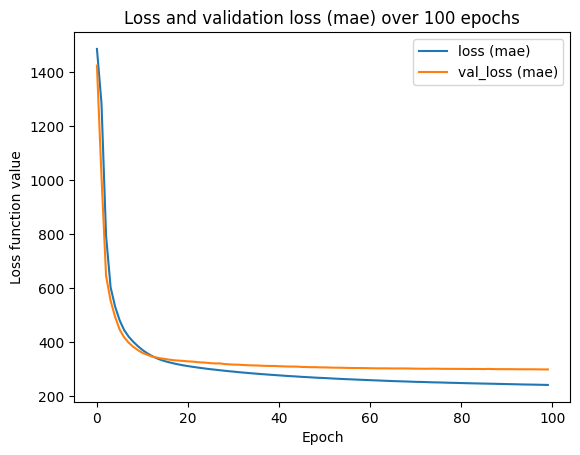

In [200]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss (mae)', 'val_loss (mae)'])
plt.xlabel("Epoch")
plt.ylabel("Loss function value")
plt.title("Loss and validation loss (mae) over 100 epochs")

Text(0.5, 1.0, 'Loss and validation loss (mse) over 100 epochs')

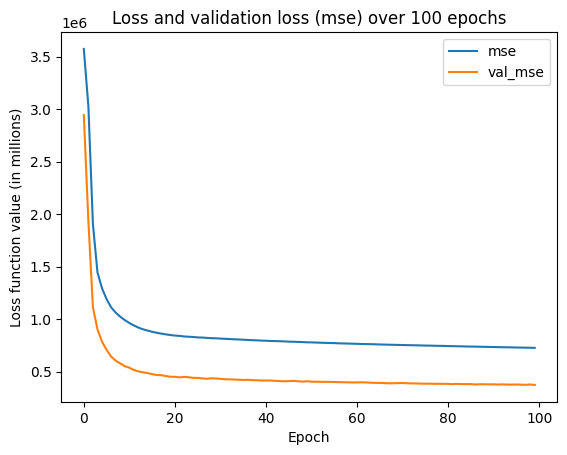

In [201]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend(['mse', 'val_mse'])
plt.xlabel("Epoch")
plt.ylabel("Loss function value (in millions)")
plt.title("Loss and validation loss (mse) over 100 epochs")

In [202]:
X_test

,bathrooms,bedrooms,square_feet,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
4122,1.0,2.0,0.016266,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4065,1.0,1.0,0.016141,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1731,1.0,1.0,0.012131,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4740,1.0,1.0,0.017269,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
6391,1.5,1.0,0.021279,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,1.0,1.0,0.015639,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8283,2.0,2.0,0.028672,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7851,2.0,2.0,0.026392,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1095,1.0,3.0,0.010376,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)

250/250 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'Model predictions of price vs the actual price on the test set measured by the number of bedrooms')

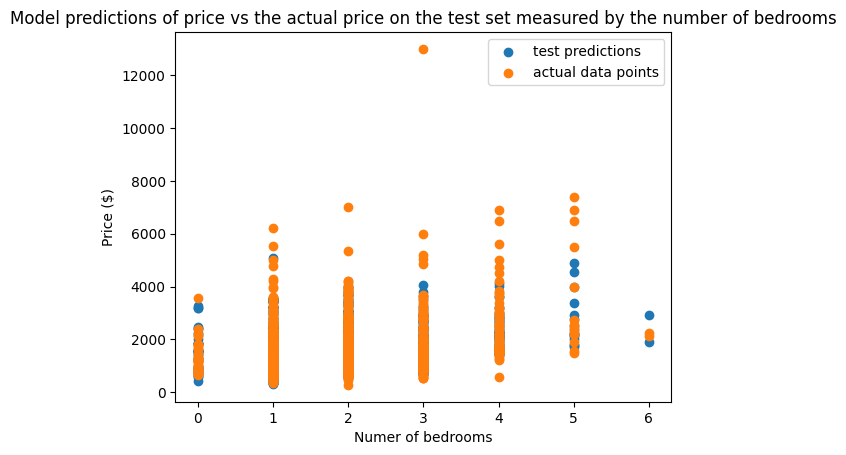

In [230]:
plt.scatter(X_test['bedrooms'], yhat_test)
plt.scatter(X_test['bedrooms'], y_test)
plt.legend(['test predictions', 'actual data points'])
plt.xlabel("Numer of bedrooms")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the test set measured by the number of bedrooms")

Text(0.5, 1.0, 'Model predictions of price vs the actual price on the training set measured by the number of bedrooms')

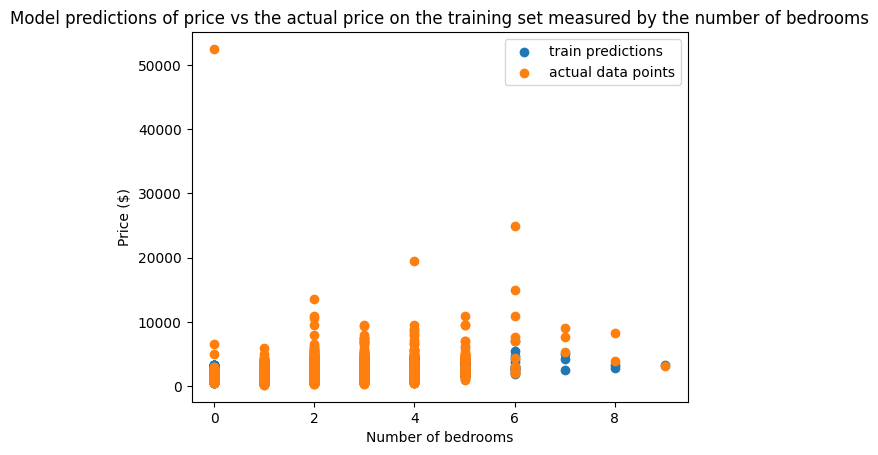

In [237]:
plt.scatter(X_train['bedrooms'], yhat_train)
plt.scatter(X_train['bedrooms'], y_train)
plt.legend(['train predictions', 'actual data points'])
plt.xlabel("Number of bedrooms")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the training set measured by the number of bedrooms")

Text(0.5, 1.0, 'Model predictions of price vs the actual price on the test set measured by the number of bathrooms')

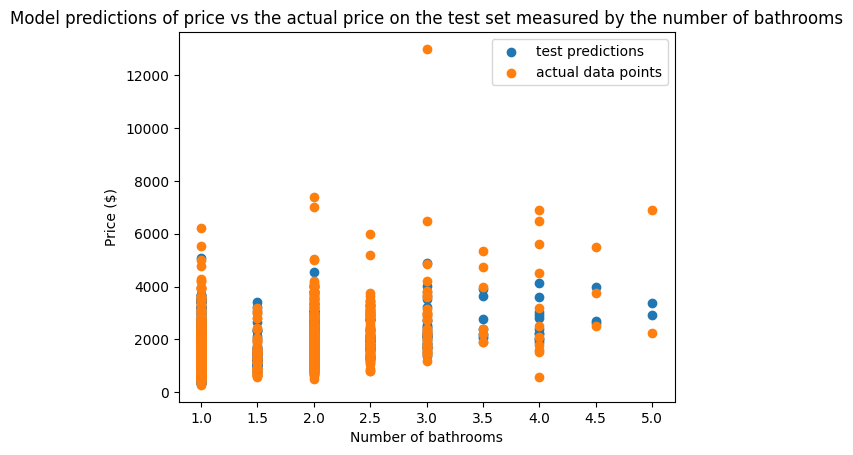

In [232]:
plt.scatter(X_test['bathrooms'], yhat_test)
plt.scatter(X_test['bathrooms'], y_test)
plt.legend(['test predictions', 'actual data points'])
plt.xlabel("Number of bathrooms")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the test set measured by the number of bathrooms")

Text(0.5, 1.0, 'Model predictions of price vs the actual price on the training set measured by the number of bathrooms')

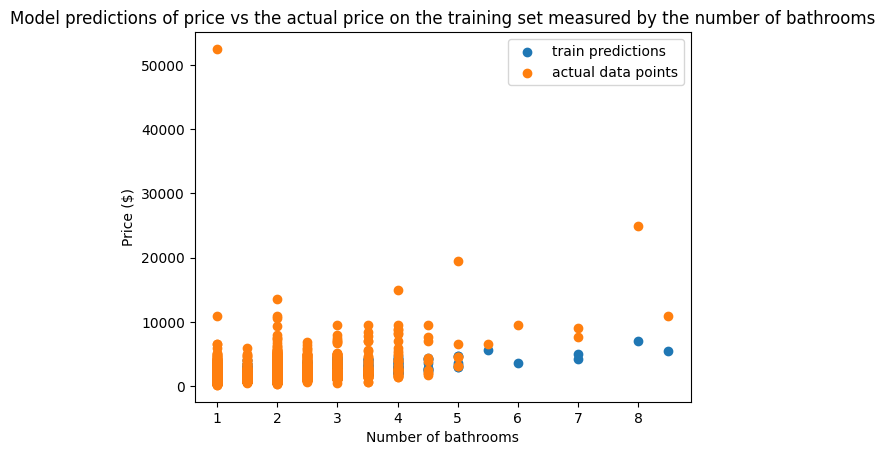

In [236]:
plt.scatter(X_train['bathrooms'], yhat_train)
plt.scatter(X_train['bathrooms'], y_train)
plt.legend(['train predictions', 'actual data points'])
plt.xlabel("Number of bathrooms")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the training set measured by the number of bathrooms")

Text(0.5, 1.0, 'Model predictions of price vs the actual price on the test set measured by the area of the apartment')

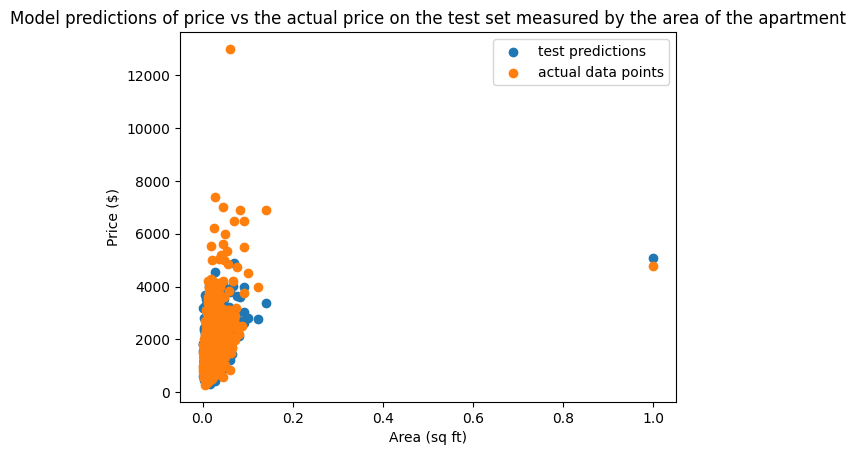

In [233]:
plt.scatter(X_test['square_feet'], yhat_test)
plt.scatter(X_test['square_feet'], y_test)
plt.legend(['test predictions', 'actual data points'])
plt.xlabel("Area (sq ft)")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the test set measured by the area of the apartment")

Text(0.5, 1.0, 'Model predictions of price vs the actual price on the training set measured by the area of the apartment')

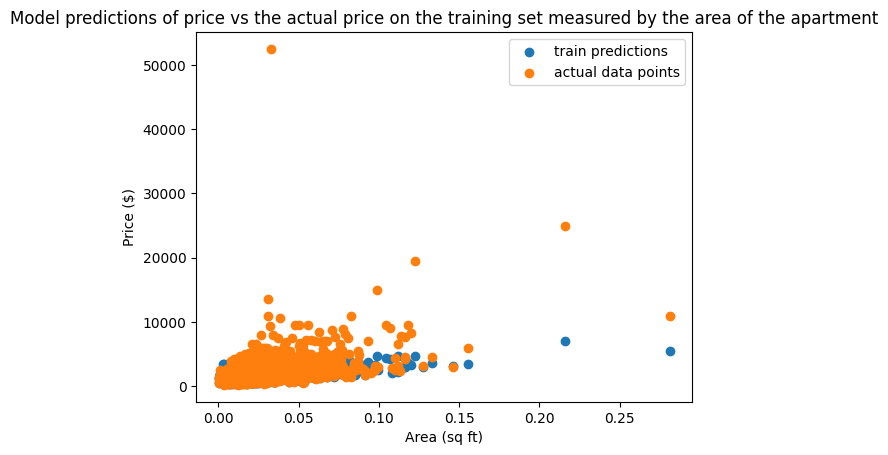

In [234]:
plt.scatter(X_train['square_feet'], yhat_train)
plt.scatter(X_train['square_feet'], y_train)
plt.legend(['train predictions', 'actual data points'])
plt.xlabel("Area (sq ft)")
plt.ylabel("Price ($)")
plt.title("Model predictions of price vs the actual price on the training set measured by the area of the apartment")

# Next Models: Linear Regression and Gradient Boosting Machines